# Movie Recommender System

###### Recommender System
A recommendation system (or recommender system) is a class of machine learning that uses data to help predict, narrow down, and find what people are looking for among an exponentially growing number of options.


#### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Loading the data set into pandas DataFrame

In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [3]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


###### Merge the credit dataframe into movie dataframe on column title

In [5]:
movies = movies.merge(credits, on='title')  ## title is not repeated here
movies.shape

(4809, 23)

##### Types of Recommender System
###### 1. Content-Based
A Content-Based Recommender works by the data that we take from the user, either explicitly (rating) or implicitly (clicking on a link). By the data we create a user profile, which is then used to suggest to the user, as the user provides more input or take more actions on the recommendation, the engine becomes more accurate.
###### 2. Collaborative Filtering
Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

***
## Data Analysis
#### Analysing the features which will be useful for recommending

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [7]:
movies['original_language'].value_counts()

en    4510
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
ko      12
cn      12
ru      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
ta       2
cs       2
ro       2
id       2
ar       2
vi       1
sl       1
ps       1
no       1
ky       1
hu       1
pl       1
af       1
nb       1
tr       1
is       1
xx       1
te       1
el       1
Name: original_language, dtype: int64

we can see that mostly the language is english so we won't be needing this column

###### Missing Values

In [8]:
## The list of features with missing values
features_with_na = [features for features in movies.columns if movies[features].isnull().sum()>1]

for feature in features_with_na:
    print(feature, np.round(movies[feature].isnull().mean(), 4), '% missing values')

homepage 0.6438 % missing values
overview 0.0006 % missing values
runtime 0.0004 % missing values
tagline 0.1755 % missing values


###### Numerical Values

In [9]:
numerical_features = [features for features in movies.columns if movies[features].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))
movies[numerical_features].head()

Number of numerical variables:  8


,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,19995
1,300000000,285,139.082615,961000000,169.0,6.9,4500,285
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,206647
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,49026
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,49529


######  Numerical values are of two types
1. Discrete
2. Continous

###### 1. Discrete

In [10]:
discrete_feature = [features for features in numerical_features if len(movies[feature].unique())<25 and feature not in ['id'] + ['movie_id']]

print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


###### 2. Continous 

In [11]:
continuous_feature = [feature for feature in numerical_features if feature not in discrete_feature+['id']+['movie_id']]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 6


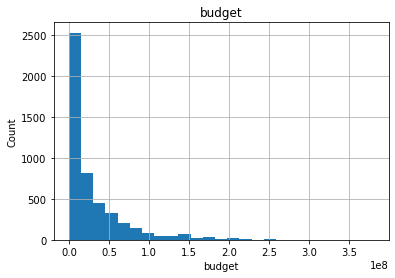

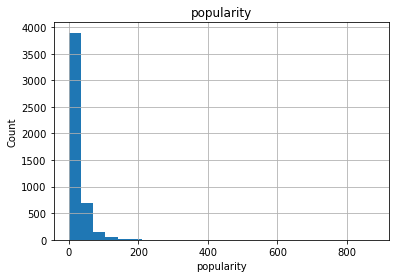

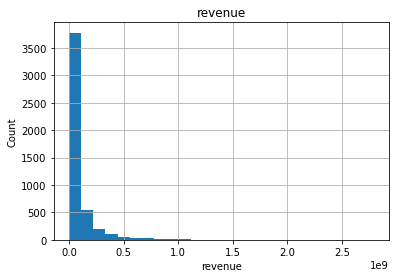

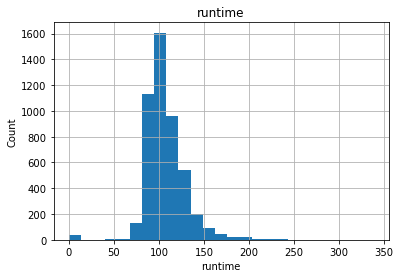

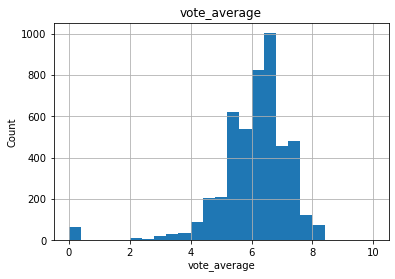

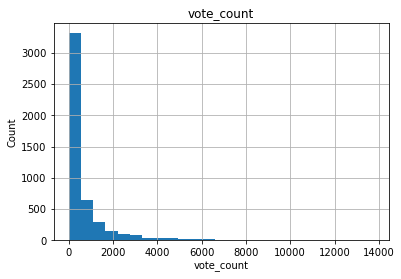

In [12]:
## Lets analyse the continuous values by creating histograms to understand the distribution

for feature in continuous_feature:
    data=movies.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

* We can see that not all the features are normally distributed and are skewed

###### Categorical Variables


In [13]:
categorical_features = [feature for feature in movies.columns if movies[feature].dtypes == 'O']
movies[categorical_features].head(2)

,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,cast,crew
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


CARDINALITY OF THE CATEGORICAL FEATURE

In [14]:
for feature in categorical_features:
    print("The feature is {} and the number of categories are {}".format(feature, len(movies[feature].unique())))

The feature is genres and the number of categories are 1175
The feature is homepage and the number of categories are 1692
The feature is keywords and the number of categories are 4222
The feature is original_language and the number of categories are 37
The feature is original_title and the number of categories are 4801
The feature is overview and the number of categories are 4801
The feature is production_companies and the number of categories are 3697
The feature is production_countries and the number of categories are 469
The feature is release_date and the number of categories are 3281
The feature is spoken_languages and the number of categories are 544
The feature is status and the number of categories are 3
The feature is tagline and the number of categories are 3945
The feature is title and the number of categories are 4800
The feature is cast and the number of categories are 4761
The feature is crew and the number of categories are 4776


---
###### The features
1. Budget: Budget high or low will not matter in recommending a movie
2. Genres: This is will be an important factor as a person may like a                  specific genre movie
3. HomePage: It has links to homepage of the movie(not imp)
4. id: we will have to keep this for our reference to a movie(sa this is          unique)
5. keywords: Important as similar movies may have some keywords matching
6. original_language: we can see that mostly the language is english so we                       won't be needing this column
7. original_title: we already have a unique title field so no need of this
8. overview: This will be one of the major feature to be used
9. popularity: It can be important but here we are creating a tag and as                  poularity is numeric quantity so we are droping it.
10. production_companies: won't be mattering much.
11. production_countries: won't be mattering much.
12. release_date: quite a important factor but is number so we are droping                   it for now.
13. revenue: quite a important factor but is number so we are droping                   it for now.
14. runtime: quite a important factor but is number so we are droping                   it for now.
15. spoken_languages: won't be mattering much.
16. status: released or non-released , not an important factor
17. tagline: not considering as overview will cover it up.
18. title: is considered
19. vote_average: quite a important factor but is number so we are droping                   it for now.
20. vote_count: quite a important factor but is number so we are droping                   it for now.
21. movie_id: not considering
22. cast: important factor and we are considering
23. crew: important factor and we are considering

## Feature Engineering

###### Handling the missing Values

In [15]:
## first we will see for categorical fetures

features_nan_categorical = [feature for feature in movies.columns if movies[feature].isnull().sum()>1 and movies[feature].dtypes == 'O']

for feature in features_with_na:
  print("{}: {}% missing values".format(feature, np.round(movies[feature].isnull().mean(),5)))

homepage: 0.64379% missing values
overview: 0.00062% missing values
runtime: 0.00042% missing values
tagline: 0.1755% missing values


we make the NAN value a new category named "Missing" 

In [16]:
def replace_cat_feature(movies, features_nan_categorical):
  data = movies.copy();
  data[features_nan_categorical] = data[features_nan_categorical].fillna('Missing')
  return data

movies = replace_cat_feature(movies, features_nan_categorical)

movies[features_nan_categorical].isnull().sum()

homepage    0
overview    0
tagline     0
dtype: int64

All the missing values have been converted to Missing category

#### Final Features selected for further training
1. genres
2. id
3. title
4. overview
5. cast
6. crew

In [17]:
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Now we have our final data prepared.

###### Now we will extract the keywords from dictionaries datatypes like genres, keywords, cast and crew

In [18]:
import ast

In [19]:
## this function extracts the genre keywords in a list
def convert(obj):
    L  = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [20]:
movies['genres'] = movies['genres'].apply(convert)

In [21]:
movies['keywords'] = movies['keywords'].apply(convert)

* In cast we have many cast but we will choose the first three cast members as they are most important

In [22]:
movies['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [23]:
## to extract top 3 cast 
def convert3(obj):
    L  = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter += 1
        else:
            break
    return L

In [24]:
movies['cast'] = movies['cast'].apply(convert3)

* For the crew we will only extract the director

In [25]:
def fetchDirector(obj):
    L  = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L

In [26]:
movies['crew'] = movies['crew'].apply(fetchDirector)

* convert the overview column into a list of values

In [27]:
movies['overview']=  movies['overview'].apply(lambda x:x.split())

>Now we have the columns (which will be used as tags) stored in the form of list

* We will remove the spaces if present in the string of the four columns we are concerned about

In [28]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ", "") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ", "") for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ", "") for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ", "") for i in x])

In [29]:
## concat the last five columns into one as it will serve as tag
movies['tags'] = movies['overview']+movies['genres']+movies['keywords']+movies['cast']+movies['crew']
movies = movies[['movie_id', 'title', 'tags']]
movies.head(2)

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."


In [30]:
## make the tags into string and make in lowercase
movies['tags'] = movies['tags'].apply(lambda x:" ".join(x))
movies['tags'] = movies['tags'].apply(lambda x:x.lower())
movies.head(2)

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."


we can see that the tags has words like ability, abilities which should be more or less same
So we will do **stemming** to convert this into same word using **nltk**

In [36]:
!pip install nltk
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [37]:
def stem(text):
    y = []
    
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

In [38]:
movies['tags'] = movies['tags'].apply(stem)

### Text Vectorization
In programming, a vector is a data structure that is similar to a list or an array. For the purpose of input representation, it is simply a succession of values, with the number of values representing the vector’s “dimensionality.” Vector representations contain information about the qualities of an input object. They offer a uniform format that computers can easily process.


#### Bag of Words
* simplest vectorization methods
* A BoW vector has the length of the entire vocabulary — that is, the set of unique words in the corpus
*  The vector’s values represent the frequency with which each word appears in a given text passage:

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words="english")

In [40]:
vectors = cv.fit_transform(movies['tags']).toarray()
vectors.shape

(4809, 5000)

In [41]:
cv.get_feature_names()

['000',
 '007',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '17th',
 '18',
 '18th',
 '18thcenturi',
 '19',
 '1910',
 '1920',
 '1930',
 '1940',
 '1944',
 '1950',
 '1950s',
 '1960',
 '1960s',
 '1970',
 '1970s',
 '1971',
 '1974',
 '1976',
 '1980',
 '1985',
 '1990',
 '1999',
 '19th',
 '19thcenturi',
 '20',
 '200',
 '2003',
 '2009',
 '20th',
 '21st',
 '23',
 '24',
 '25',
 '30',
 '300',
 '3d',
 '40',
 '50',
 '500',
 '60',
 '70',
 '80',
 'aaron',
 'aaroneckhart',
 'abandon',
 'abduct',
 'abigailbreslin',
 'abil',
 'abl',
 'aboard',
 'abov',
 'abus',
 'academ',
 'academi',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accomplish',
 'account',
 'accus',
 'ace',
 'achiev',
 'acquaint',
 'act',
 'action',
 'actionhero',
 'activ',
 'activist',
 'activities',
 'actor',
 'actress',
 'actual',
 'ad',
 'adam',
 'adamsandl',
 'adamshankman',
 'adapt',
 'add',
 'addict',
 'adjust',
 'admir',
 'admit',
 'adolesc',
 'adopt',
 'ador',
 'adrienbrodi',
 'adult'

### Similarity Matrix using Cosine Similarity
* Cosine similarity measures the similarity between two vectors of an inner product space
* It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction
* It is often used to measure document similarity in text analysis

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)

In [43]:
similarity[1]

array([0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
       0.02615329])

___

###### Further steps to take to build the recommender system
1. We will use the similarity matrix to get the most similar movies
2. we will take a target movie and then we will locate the target movie in the similarity matrix column
3. then we will **Enumerate** the data i.e store the index along with the similarity coefficient( doing this will makes sure we don't loose track of the similar movie index once the target similarity row is sorted)
4. then we will sort the target similarity row and then return the top 5 most similar movie title name

In [52]:
def recommend(movie):
    movie_index = movies[movies['title'] == movie].index[0]   ## 1.
    distances = similarity[movie_index]                        ## 2.
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])  ## 3.
    for i in movies_list[1:6]:   ## 4.
        print(movies.iloc[i[0]].title)

In [53]:
## 1. -> the index of target movie
## 2. -> get the distance array(col) from similarity matrix
## 3. -> list of movies in sorted order
##  -> normal -> [0.232,0.588,....0.76] ennumerate-> [(0,0.232),(1,0.588),....(4809,0.76)] ennumerate gives index
## -> lambda function specifies that sorting is to be done on the basis of similarity and not index
## 4. [1:6] top 5 movies selected from sorted

In [55]:
recommend('Batman Begins')

The Dark Knight
Batman
Batman
The Dark Knight Rises
10th & Wolf


## Pickling the model

In [56]:
import pickle

In [58]:

pickle.dump(movies.to_dict(), open('movies_dict.pkl', 'wb'))

In [62]:

pickle.dump(similarity,open('similarity.pkl', 'wb'))